In [3]:
# import useful libraries
import numpy as np
#import healpy as hp
import matplotlib.pyplot as plt

import os
import sys

# add parent directory to sys.path to import STL package modules
PARENT_DIR = os.path.dirname(os.path.abspath(os.getcwd() + "../../../"))
sys.path.append(PARENT_DIR)
print("Parent directory added to sys.path:", ".../" + PARENT_DIR.split("/")[-1])

# test data directory
DATA_TEST_PATH = PARENT_DIR + "/data" + "/test"
print("Dataset dirctory used:", ".../" + PARENT_DIR.split("/")[-1] + DATA_TEST_PATH.split(PARENT_DIR.split("/")[-1])[-1])


from STL_main.STL_Healpix_Kernel_Torch import STL_Healpix_Kernel_Torch as DataClass
from STL_main.ST_Operator import ST_Operator as SO
from STL_main.Synthesis import optimize_scattering_LBFGS

Parent directory added to sys.path: .../STL-Dev
Dataset dirctory used: .../STL-Dev/data/test


ModuleNotFoundError: No module named 'foscat'

In [2]:
nside=32

im=np.random.rand(12*nside**2)
data=DataClass(im)

# test wavelet computation

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


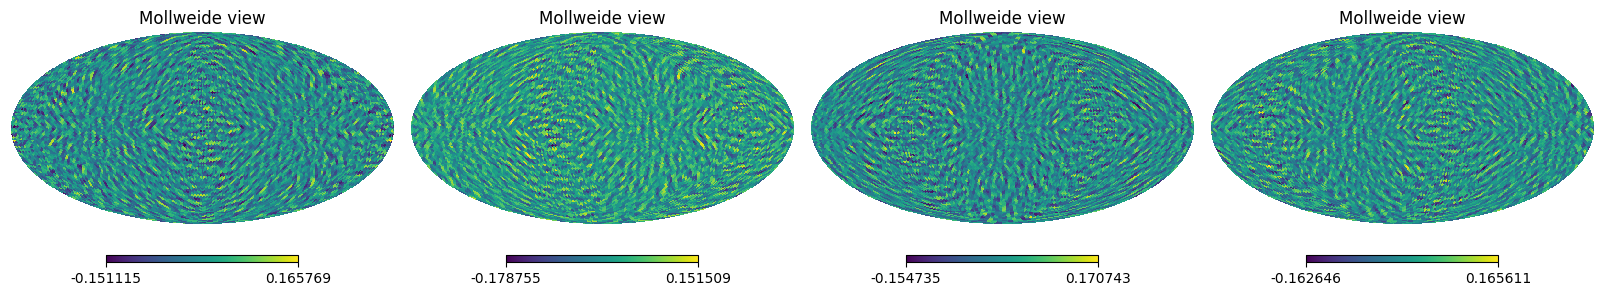

In [3]:
w_op=data.get_wavelet_op()

w_data = w_op.apply(data,0).array

plt.figure(figsize=(16,6))
for k in range(4):
    hp.mollview(w_data[k].cpu().numpy(),nest=True,hold=False,sub=(1,4,1+k))

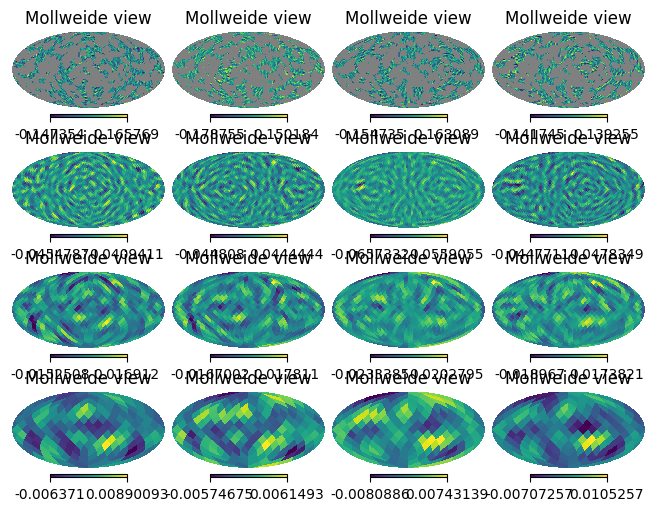

In [4]:
tmp=im.copy()
tmp[(np.random.rand(300)*12*nside**2).astype('int')]=np.nan

def unan(x):
    x[np.isnan(x)]=hp.UNSEEN
    return x
l_data=DataClass(tmp)

for j in range(4):
    w_data = w_op.apply(l_data,j).array
    for k in range(4):
        hp.mollview(unan(w_data[k].cpu().numpy()),nest=True,hold=False,sub=(4,4,1+k+4*j))
    
    #l_data=w_op.apply_smooth(l_data,copy=True)
    l_data=w_op.nandownsample(l_data,j+1)

In [5]:
from ST_Operator import ST_Operator as SO

l_data=DataClass(im)

st_op=SO(l_data)

st_data = st_op.apply(l_data)
st_data_nan = st_op.apply(DataClass(tmp),use_NaN=True)

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


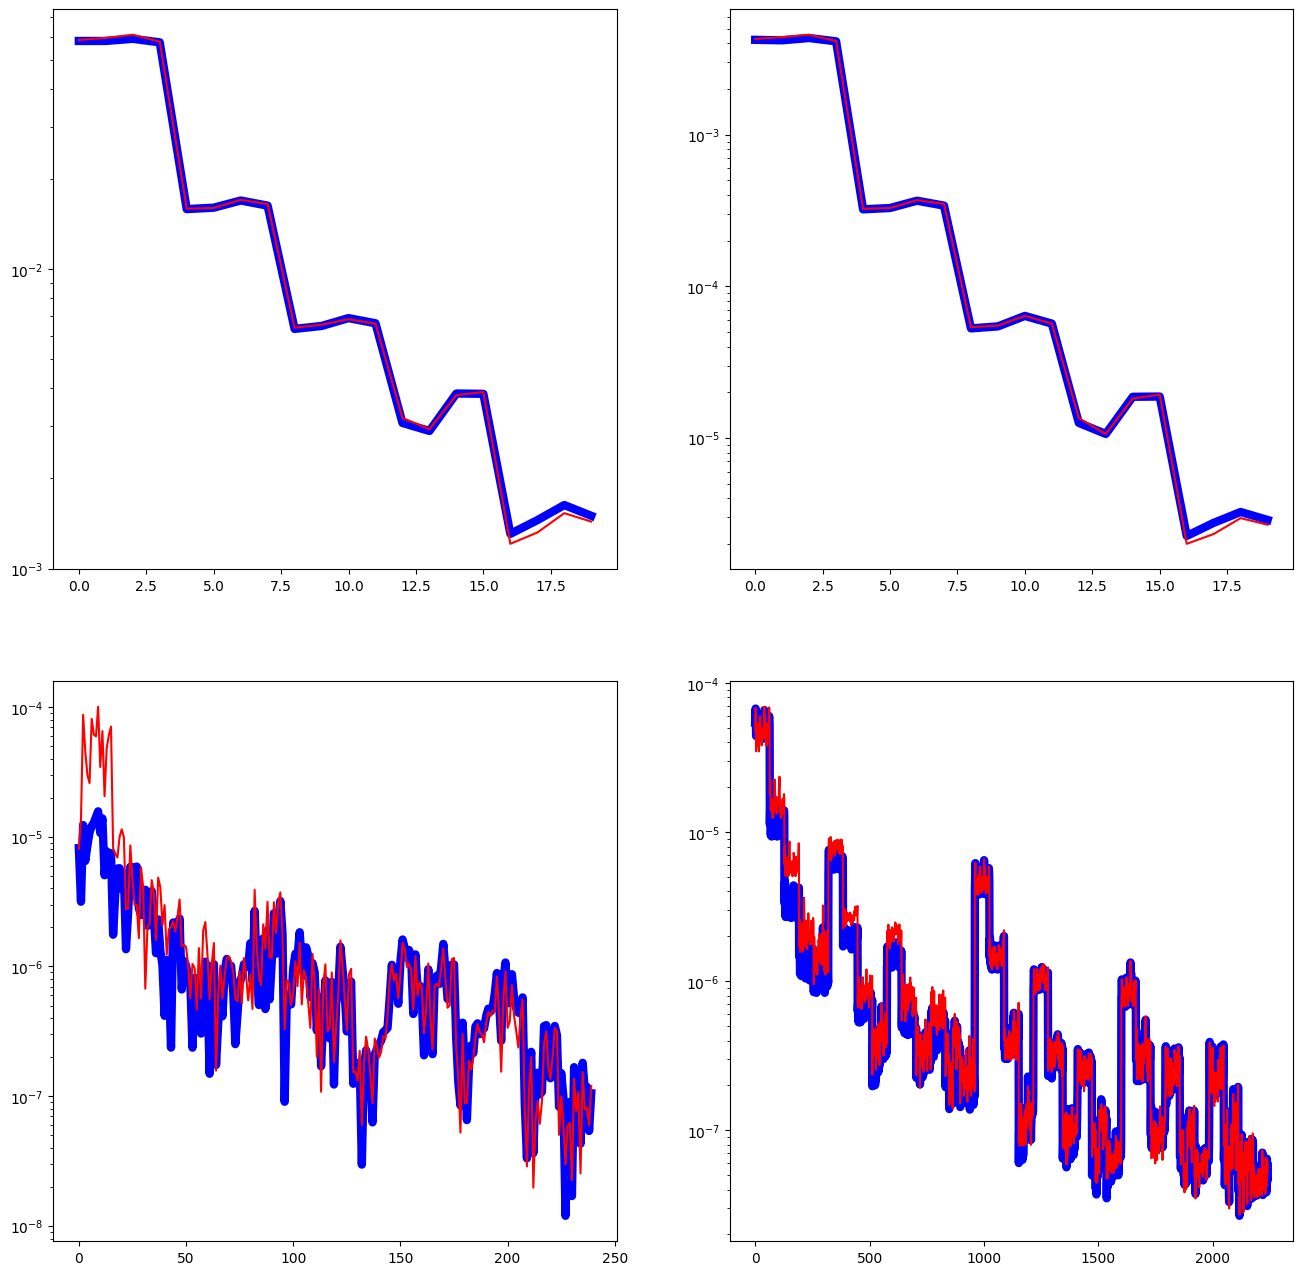

In [6]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.plot(st_data.S1.cpu().numpy().flatten(),color='b',lw=6)
plt.plot(st_data_nan.S1.cpu().numpy().flatten(),color='r')
plt.yscale('log')
plt.subplot(2,2,2)
plt.plot(st_data.S2.cpu().numpy().flatten(),color='b',lw=6)
plt.plot(st_data_nan.S2.cpu().numpy().flatten(),color='r')
plt.yscale('log')
def r_nan(x):
    return x[np.isfinite(x)]
plt.subplot(2,2,3)
plt.plot(r_nan(st_data.S3.abs().cpu().numpy().flatten()),color='b',lw=6)
plt.plot(r_nan(st_data_nan.S3.abs().cpu().numpy().flatten()),color='r')
plt.yscale('log')
plt.subplot(2,2,4)
plt.plot(r_nan(st_data.S4.cpu().numpy().flatten()),color='b',lw=6)
plt.plot(r_nan(st_data_nan.S4.cpu().numpy().flatten()),color='r')
plt.yscale('log')

# do synthesis

In [7]:
st_data = st_op.apply(l_data)
st_data_norm = st_op.apply(l_data,norm='store_ref')

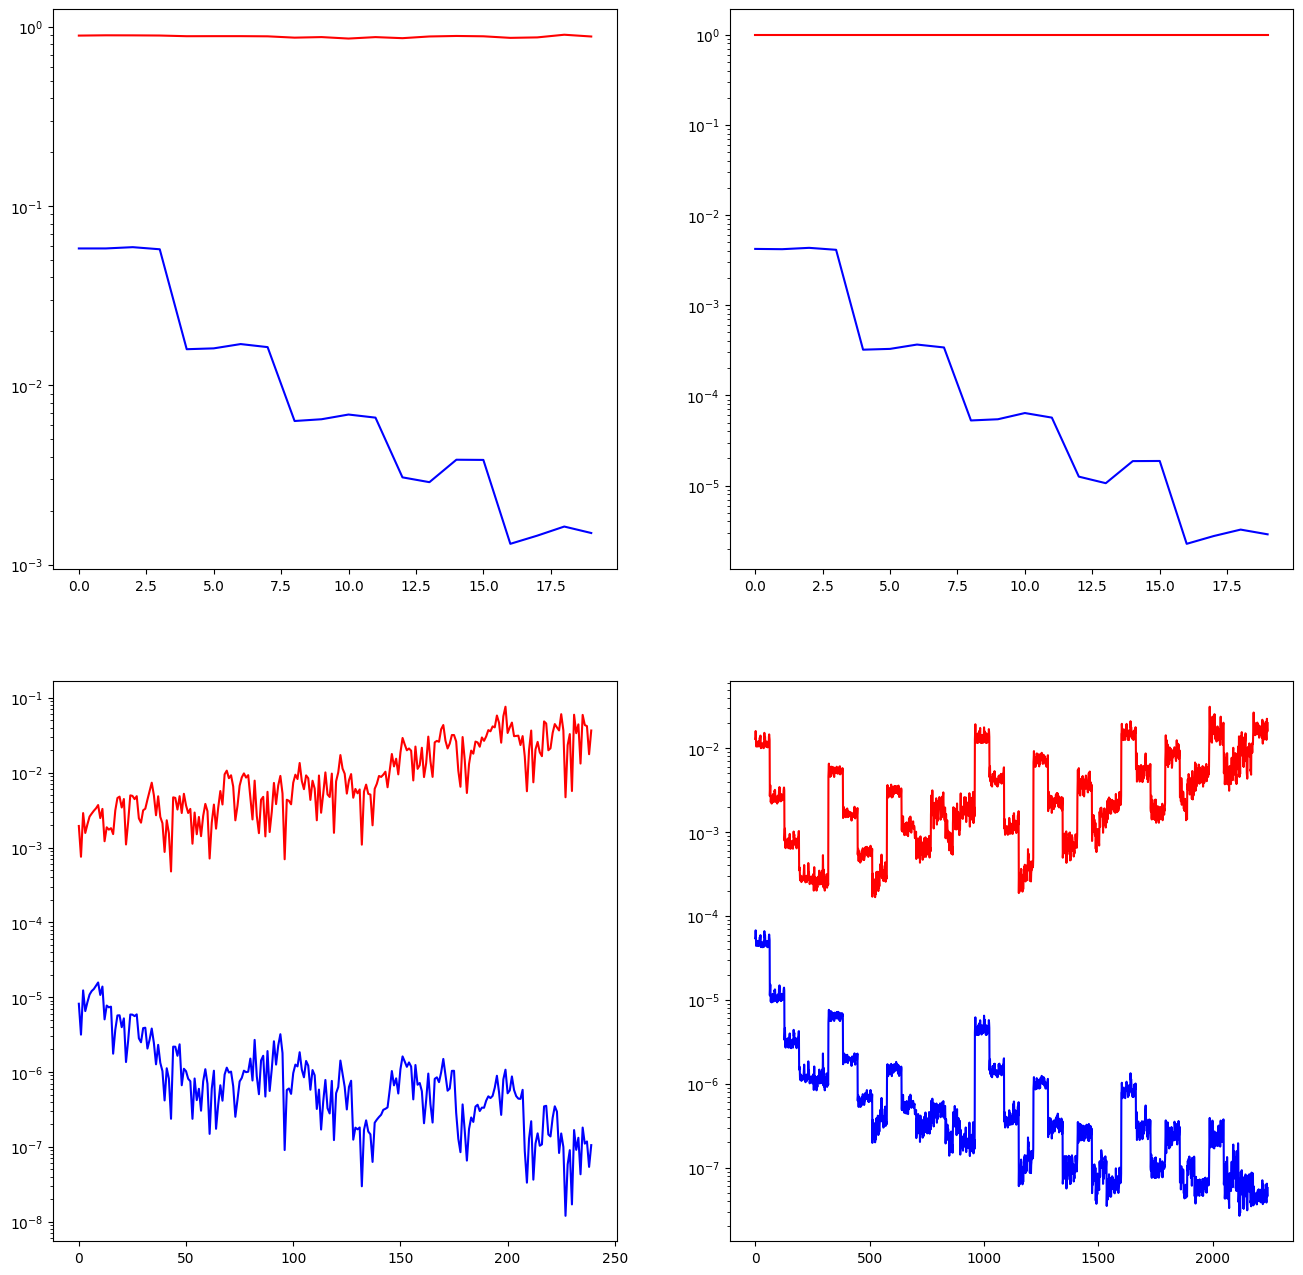

In [8]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.plot(st_data.S1.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S1.cpu().numpy().flatten(),color='r')
plt.yscale('log')
plt.subplot(2,2,2)
plt.plot(st_data.S2.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S2.cpu().numpy().flatten(),color='r')
plt.yscale('log')
def r_nan(x):
    return x[np.isfinite(x)]
plt.subplot(2,2,3)
plt.plot(r_nan(st_data.S3.abs().cpu().numpy().flatten()),color='b')
plt.plot(r_nan(st_data_norm.S3.abs().cpu().numpy().flatten()),color='r')
plt.yscale('log')
plt.subplot(2,2,4)
plt.plot(r_nan(st_data.S4.cpu().numpy().flatten()),color='b')
plt.plot(r_nan(st_data_norm.S4.cpu().numpy().flatten()),color='r')
plt.yscale('log')

# do synthesis

In [4]:
heal_im=np.load(DATA_TEST_PATH + "/" + "Test_Heal_LSS.npy")

nside=32
heal_im = np.mean(heal_im.reshape(12*nside**2,heal_im.shape[0]//(12*nside**2)),1)

data = DataClass(heal_im)
w_op = data.get_wavelet_op()

#Build the smooth version
target = w_op.apply_smooth(data).array.cpu().numpy()

nan_target = target.copy()

nan_target[(np.random.rand(300)*12*nside**2).astype('int')]=np.nan
nan_target[56:96]=np.nan

NameError: name 'DataClass' is not defined

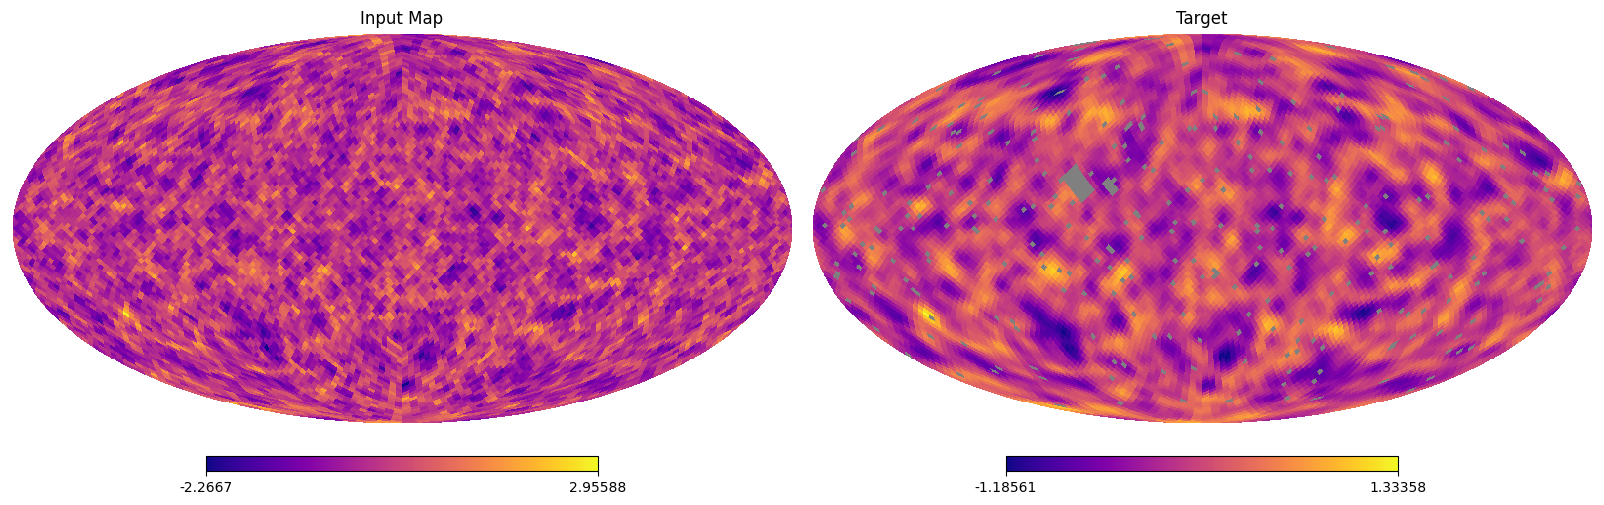

In [10]:
plt.figure(figsize=(16,6))
hp.mollview(heal_im,nest=True,hold=False,sub=(1,2,1),cmap='plasma',title='Input Map')
hp.mollview(nan_target,nest=True,hold=False,sub=(1,2,2),cmap='plasma',title='Target')

In [11]:
u,histo = optimize_scattering_LBFGS(
        target,
        DataClass,
        SO,
        max_iter=100,
        lr=1.0,
        history_size=50,
        verbose=True,
    )

[LBFGS] inner iter 10, loss = 7.039328e+00
[LBFGS] inner iter 20, loss = 9.276508e-01
[LBFGS] inner iter 30, loss = 2.297592e-01
[LBFGS] inner iter 40, loss = 1.074161e-01
[LBFGS] inner iter 50, loss = 6.111540e-02
[LBFGS] inner iter 60, loss = 4.239249e-02
[LBFGS] inner iter 70, loss = 3.021649e-02
[LBFGS] inner iter 80, loss = 2.375582e-02
[LBFGS] inner iter 90, loss = 1.906492e-02
[LBFGS] inner iter 100, loss = 1.649608e-02
[LBFGS] inner iter 110, loss = 1.526710e-02


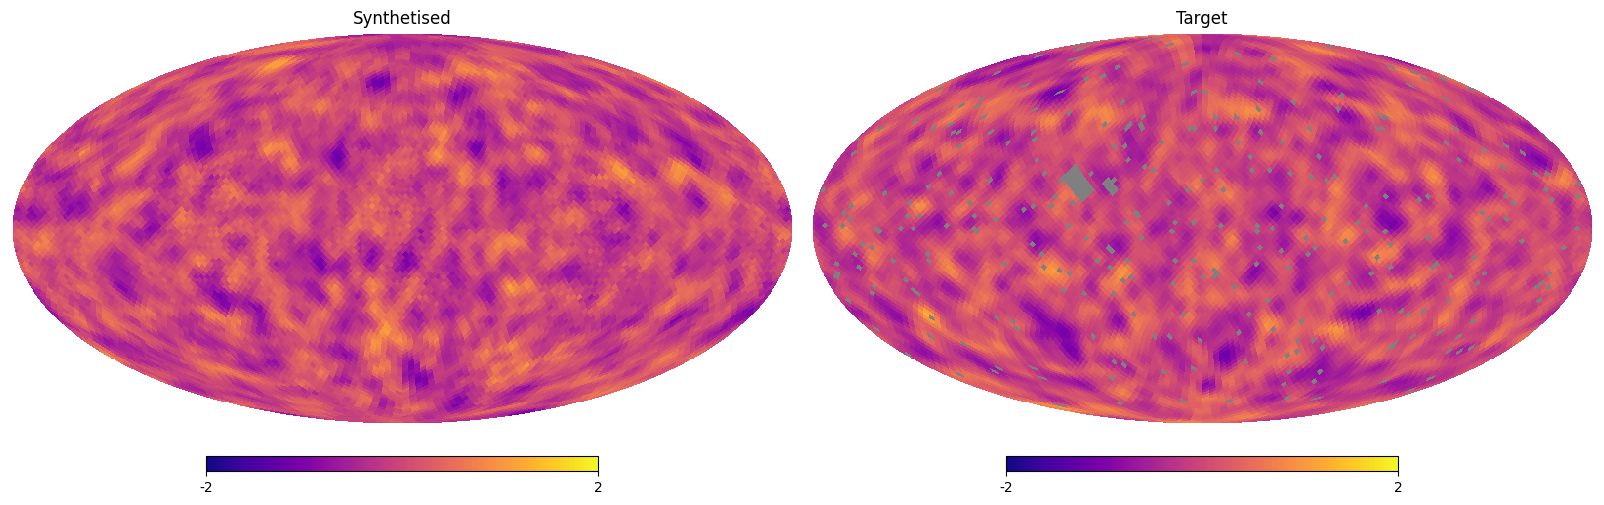

In [12]:
plt.figure(figsize=(16,6))
hp.mollview(u.cpu().numpy(),nest=True,hold=False,sub=(1,2,1),cmap='plasma',title='Synthetised',min=-2,max=2)
hp.mollview(nan_target,nest=True,hold=False,sub=(1,2,2),cmap='plasma',title='Target',min=-2,max=2)

In [18]:
from STL_utils import Gaussianise

g = Gaussianise(nan_target[np.isfinite(nan_target)])
g_target=g.forward(nan_target).cpu().numpy()

gu,histo = optimize_scattering_LBFGS(
        g_target,
        DataClass,
        SO,
        nbatch=4,
        max_iter=100,
        lr=1.0,
        print_iter=1,
        history_size=50,
        verbose=True)

u = g.invert(gu)

NaN detected in the target, the synthesis takes it into account
[LBFGS] inner iter 1, loss = 2.220054e+01
[LBFGS] inner iter 2, loss = 2.219938e+01
[LBFGS] inner iter 3, loss = 2.218914e+01
[LBFGS] inner iter 4, loss = 2.210530e+01
[LBFGS] inner iter 5, loss = 2.182497e+01
[LBFGS] inner iter 6, loss = 2.142812e+01
[LBFGS] inner iter 7, loss = 2.067663e+01
[LBFGS] inner iter 8, loss = 1.868059e+01
[LBFGS] inner iter 9, loss = 1.546472e+01
[LBFGS] inner iter 10, loss = 1.402542e+01
[LBFGS] inner iter 11, loss = 1.030020e+01
[LBFGS] inner iter 12, loss = 9.276352e+00
[LBFGS] inner iter 13, loss = 7.746527e+00
[LBFGS] inner iter 14, loss = 5.559721e+00
[LBFGS] inner iter 15, loss = 4.317013e+00
[LBFGS] inner iter 16, loss = 2.827231e+00
[LBFGS] inner iter 17, loss = 1.248113e+00
[LBFGS] inner iter 18, loss = 1.135517e+00
[LBFGS] inner iter 19, loss = 4.745383e-01
[LBFGS] inner iter 20, loss = 4.246009e-01
[LBFGS] inner iter 21, loss = 3.641083e-01
[LBFGS] inner iter 22, loss = 3.468617e-01

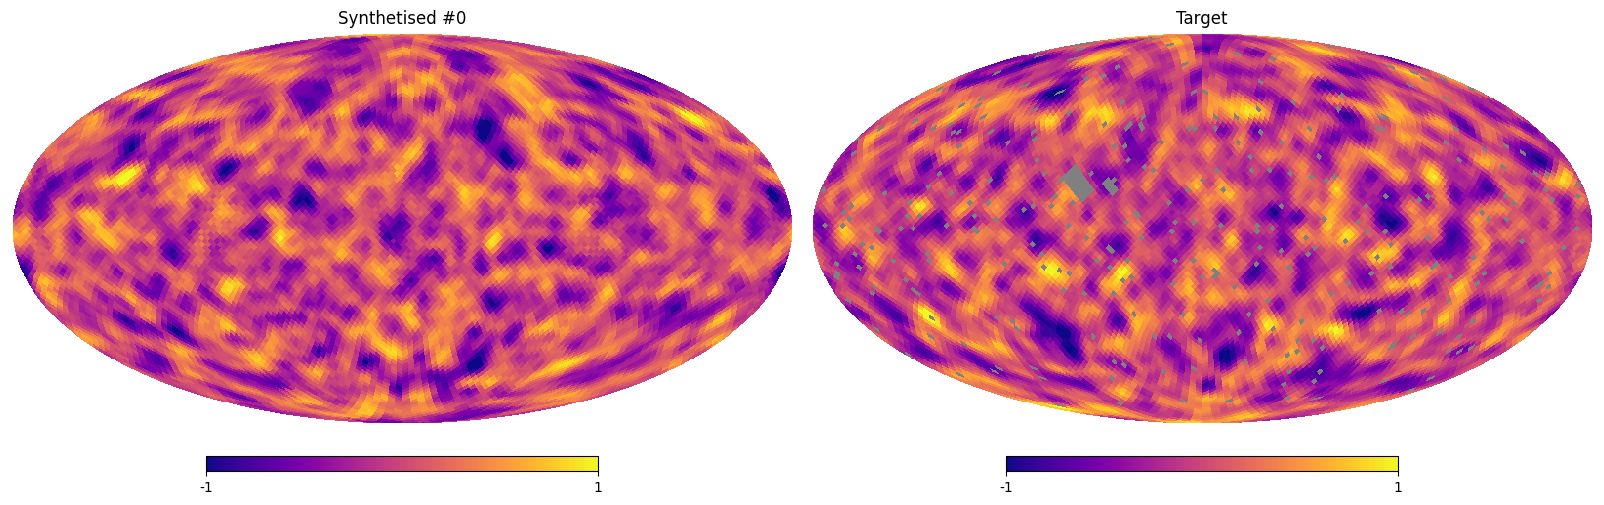

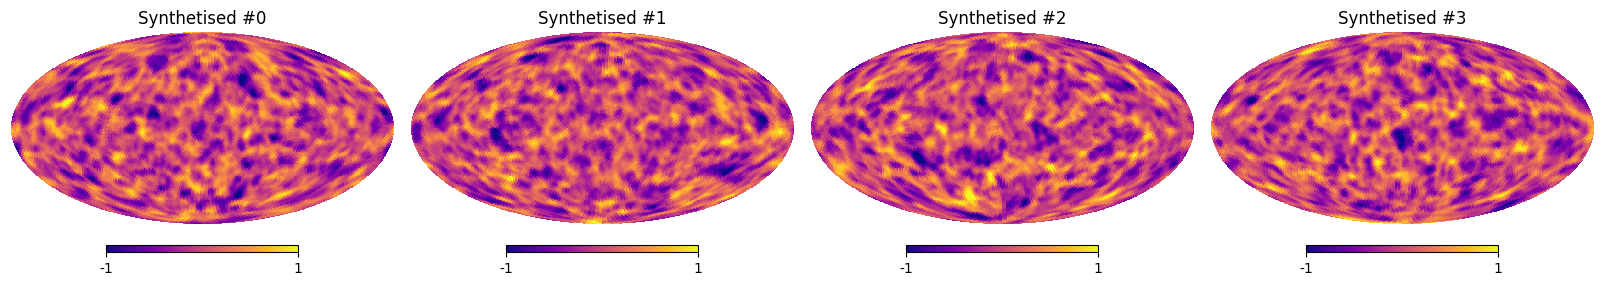

In [21]:
plt.figure(figsize=(16,6))
hp.mollview(u[0].cpu().numpy(),nest=True,hold=False,sub=(1,2,1),cmap='plasma',title='Synthetised #0',min=-1,max=1)
hp.mollview(nan_target,nest=True,hold=False,sub=(1,2,2),cmap='plasma',title='Target',min=-1,max=1)
plt.figure(figsize=(16,4))
for k in range(4):
    hp.mollview(u[k].cpu().numpy(),nest=True,hold=False,sub=(1,4,1+k),
                cmap='plasma',title='Synthetised #%d'%(k),min=-1,max=1)

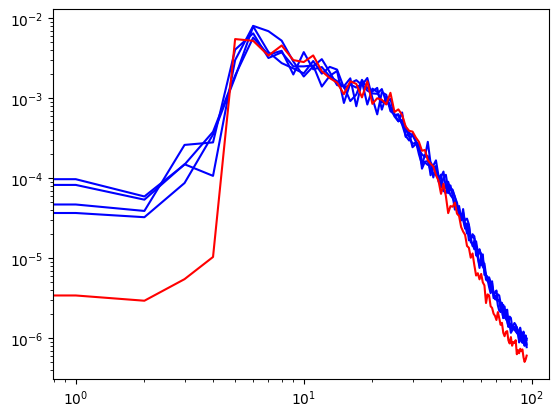

In [22]:
for k in range(4):
    cl1=hp.anafast(hp.reorder(u[k].cpu().numpy(),n2r=True))
    plt.plot(cl1,color='b')
cl2=hp.anafast(hp.reorder(target,n2r=True))
plt.plot(cl2,color='r')
plt.yscale('log')
plt.xscale('log')